# Plots for VAE
This notebook produces the plots that were used in the paper.

Some cell outputs have been omitted for readability.

In [1]:
import sys
import random
sys.path.append('.')
import dataset

import numpy as np
from tqdm.auto import tqdm, trange

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
X_train, X_valid, X_test = dataset.load_datasets()

In [3]:
# For final submission:
train_on_full_dataset = False
if train_on_full_dataset:
    import scipy
    X_train = X_train + X_valid
# use this only for the final prediction, not for training

In [4]:
X_train.count_nonzero(), X_valid.count_nonzero(), X_test.count_nonzero()
valid_indices = list(set(zip(X_train.nonzero()[0], X_train.nonzero()[1])))

In [5]:
class Autoencoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.user_dim = 10000
        self.item_dim = 1000
        
        self.layer_1 = nn.Linear(1000, 100)
        self.layer_1a = nn.Linear(100, 100)
        
        self.vae = nn.Linear(100, 100)
        
        self.layer_3 = nn.Linear(50, 100)
        
        self.cls_layer = nn.Linear(100, 1000)
    
    def forward(self, data):
        net_data = data

        # Encoder layers
        net_data = F.relu(self.layer_1(net_data))
        net_data = F.dropout(net_data, training=self.training)
        
        net_data = F.relu(self.layer_1a(net_data))
        net_data = F.dropout(net_data, training=self.training)
        
        # VAE bottleneck
        vae = self.vae(net_data)
        mus_q, log_sigmas_q = torch.split(vae, 50, dim=-1)
        stds_q = torch.exp(0.5 * log_sigmas_q)
        
        KL = 0.5 * (-log_sigmas_q + torch.exp(log_sigmas_q) + mus_q ** 2 - 1)
        KL = torch.sum(KL, dim=-1)
        KL = torch.mean(KL)
        
        # Sample random value if training,
        # use the mean during evaluation
        if not self.training:
            sampled_z = mus_q
        else:
            eps = torch.randn(stds_q.shape, dtype=torch.float, device=device)
            sampled_z = mus_q + eps * stds_q
        
        # Decoder layers
        net_data = F.relu(self.layer_3(sampled_z))
        
        net_data = F.dropout(net_data, training=self.training)
        
        # Classification layer
        y_score = self.cls_layer(net_data)
        return y_score, KL

In [6]:
# Model initialization
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
try:
    del model
except:
    pass
model = Autoencoder().to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-4)

In [7]:
print(X_train.count_nonzero(), X_valid.count_nonzero())

def get_predictions(A):
    """Predict the full matrix using the autoencoder."""
    model.eval()
    A_pred = np.zeros((10000, 1000))
    valid_indices = list(set(zip(A.nonzero()[0], A.nonzero()[1])))
    
    # Split dataset in batches of 64 rows ...
    for i in range(0, 10000, 64):
        X = X_train[i:i+64].todense()
        X_ = torch.tensor(X, dtype=torch.float, device=device)
        y_preds, KL = model(X_)
        
        for i_ in range(y_preds.shape[0]):
            x_i = y_preds[i_].detach().cpu()
            A_pred[i+i_] = x_i
    
    return A_pred, valid_indices

def compute_loss():
    """Compute the mean squared error between the ranking matrix and predictions."""
    A_pred, valid_indices = get_predictions(X_valid)
    losses = np.square(X_valid - A_pred)
    losses = [losses[i,j] for (i, j) in valid_indices]
    mean_loss = np.mean(losses)
    return mean_loss

compute_loss()

925567 251385


16.080782337697464

In [8]:
train_indices_perline = [[] for i_ in range(10000)]
for i, j in valid_indices:
    train_indices_perline[i].append((i, j))

for line in train_indices_perline:
    assert line
assert len(train_indices_perline) == 10000

# Annealing hyperparameter

In [ ]:
anneal_alpha_max = 0.1

losses_train = {}
losses_valid = {}

for anneal_value in [0., 0.1, 0.2]:
    loss_avg = []

    anneal_alpha_max = anneal_value
    # Model initialization
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    try:
        del model
    except:
        pass
    model = Autoencoder().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=3e-4)
    
    
    MAX_ITER = 500000
    for i in range(0, MAX_ITER):
        # randomly sample 32 points from training matrix
        model.train()
        random_lines = random.sample(range(0, 10000), k=32)
        X = X_train[random_lines].todense()
        X = torch.tensor(X, dtype=torch.float, device=device)
        y_true = X

        opt.zero_grad()
        # Important: Add random noise to the input to prevent overfitting
        y_preds, KL = model(X + torch.randn(X.shape, device=device) * 0.5)

        valid_mask = torch.zeros_like(y_preds, device=device)
        for i_ in range(X.shape[0]):
            i_real = random_lines[i_]
            indices = [j for _,j in train_indices_perline[i_real]]
            valid_mask[i_, indices] = 1.0

        loss = (y_preds - y_true) ** 2
        loss = loss[valid_mask != 0.]

        anneal_alpha = (anneal_alpha_max / 500000) * i
        if i % 10000 == 0:
            print("Alpha:", anneal_alpha)

        reg_var = (model.vae.weight ** 2).mean()
        neg_ELBO = loss + anneal_alpha * KL + 2 * reg_var

        # update avg loss
        loss_avg.insert(0, loss.mean().item())
        loss_avg = loss_avg[:1000]

        if i % 1000 == 0:
            print("It %d Avg loss: %.4f" % (i, np.mean(loss_avg)))
        if i % 1000 == 0:
            mean_loss = compute_loss()
            print("Mean loss: %.4f" % mean_loss)
            losses_train.setdefault(anneal_value, []).append(np.mean(loss_avg))
            losses_valid.setdefault(anneal_value, []).append(mean_loss)

        neg_ELBO.mean().backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        opt.step()


In [11]:
import pickle
with open("plots-for-alpha.pkl", "wb") as wp:
    pickle.dump((losses_train, losses_valid), wp)

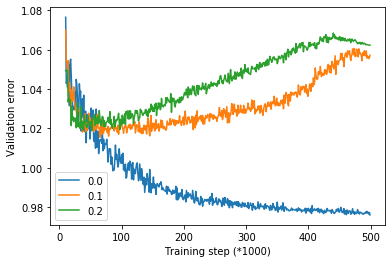

In [5]:
import pickle
import matplotlib.pyplot as plt

with open("plots-for-alpha.pkl", "rb") as wp:
    (losses_train, losses_valid) = pickle.load(wp)
# Create a plot

keys = [] 
for key in losses_valid: 
    data = losses_valid[key] 
    plt.plot(range(10, len(data)), data[10:]) 
#     print(data[-1]) 
    keys.append(key)

plt.legend(keys) 
plt.xlabel("Training step (*1000)") 
plt.ylabel("Validation error") 
plt.show()

# Random noise magnitude

In [ ]:
losses_train = {}
losses_valid = {}

for noise_magnitude in [0., 0.2, 0.5, 1.0]:
    loss_avg = []

    # Model initialization
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    try:
        del model
    except:
        pass
    model = Autoencoder().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=3e-4)
    
    
    MAX_ITER = 500000
    for i in range(0, MAX_ITER):
        # randomly sample 32 points from training matrix
        model.train()
        random_lines = random.sample(range(0, 10000), k=32)
        X = X_train[random_lines].todense()    
        X = torch.tensor(X, dtype=torch.float, device=device)
        y_true = X

        opt.zero_grad()
        # Important: Add random noise to the input to prevent overfitting
        y_preds, KL = model(X + torch.randn(X.shape, device=device) * noise_magnitude)

        valid_mask = torch.zeros_like(y_preds, device=device)
        for i_ in range(X.shape[0]):
            i_real = random_lines[i_]
            indices = [j for _,j in train_indices_perline[i_real]]
            valid_mask[i_, indices] = 1.0

        loss = (y_preds - y_true) ** 2
        loss = loss[valid_mask != 0.]

        # update avg loss
        loss_avg.insert(0, loss.mean().item())
        loss_avg = loss_avg[:1000]

        if i % 1000 == 0:
            print("It %d Avg loss: %.4f" % (i, np.mean(loss_avg)))
        if i % 1000 == 0:
            mean_loss = compute_loss()
            print("Mean loss: %.4f" % mean_loss)
            losses_train.setdefault(noise_magnitude, []).append(np.mean(loss_avg))
            losses_valid.setdefault(noise_magnitude, []).append(mean_loss)

        loss.mean().backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        opt.step()


In [ ]:
import pickle
with open("plots-for-noise.pkl", "wb") as wp:
    pickle.dump((losses_train, losses_valid), wp)

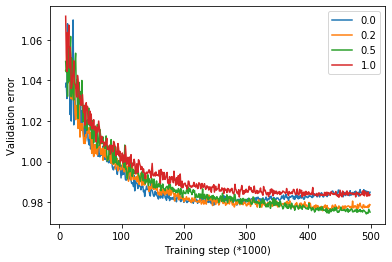

In [4]:
import pickle
import matplotlib.pyplot as plt

with open("plots-for-noise.pkl", "rb") as wp:
    (losses_train, losses_valid) = pickle.load(wp)

# Create a plot

keys = [] 
for key in losses_valid: 
    data = losses_valid[key] 
    plt.plot(range(10, len(data)), data[10:]) 
#     print(data[-1]) 
    keys.append(key)

plt.legend(keys) 
plt.xlabel("Training step (*1000)") 
plt.ylabel("Validation error") 
plt.show()

# Size of the bottleneck

In [ ]:
losses_train = {}
losses_valid = {}

for bottleneck_size in [10, 25, 50, 75]:
    loss_avg = []
    class Autoencoder(nn.Module):

        def __init__(self):
            super().__init__()
            self.user_dim = 10000
            self.item_dim = 1000

            self.layer_1 = nn.Linear(1000, 100)
            self.layer_1a = nn.Linear(100, 100)

            self.vae = nn.Linear(100, bottleneck_size * 2)

            self.layer_3 = nn.Linear(bottleneck_size, 100)
    #         self.layer_3a = nn.Linear(100, 100)

            self.cls_layer = nn.Linear(100, 1000)

        def forward(self, data):
            net_data = data

            # Encoder layers
            net_data = F.relu(self.layer_1(net_data))
            net_data = F.dropout(net_data, training=self.training)

            net_data = F.relu(self.layer_1a(net_data))
            net_data = F.dropout(net_data, training=self.training)

            # VAE bottleneck
            vae = self.vae(net_data)
            mus_q, log_sigmas_q = torch.split(vae, bottleneck_size, dim=-1)
            stds_q = torch.exp(0.5 * log_sigmas_q)

            KL = 0.5 * (-log_sigmas_q + torch.exp(log_sigmas_q) + mus_q ** 2 - 1)
            KL = torch.sum(KL, dim=-1)
            KL = torch.mean(KL)

            # Sample random value if training,
            # use the mean during evaluation
            if not self.training:
                sampled_z = mus_q
            else:
                eps = torch.randn(stds_q.shape, dtype=torch.float, device=device)
                sampled_z = mus_q + eps * stds_q

            # Decoder layers
            net_data = F.relu(self.layer_3(sampled_z))

            net_data = F.dropout(net_data, training=self.training)

            # Classification layer
            y_score = self.cls_layer(net_data)
            return y_score, KL
    
    # Model initialization
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    try:
        del model
    except:
        pass
    model = Autoencoder().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=3e-4)
    
    
    MAX_ITER = 500000
    for i in range(0, MAX_ITER):
        # randomly sample 32 points from training matrix
        model.train()
        random_lines = random.sample(range(0, 10000), k=32)
        X = X_train[random_lines].todense()
        X = torch.tensor(X, dtype=torch.float, device=device)
        y_true = X

        opt.zero_grad()
        # Important: Add random noise to the input to prevent overfitting
        y_preds, KL = model(X + torch.randn(X.shape, device=device) * 0.5)

        valid_mask = torch.zeros_like(y_preds, device=device)
        for i_ in range(X.shape[0]):
            i_real = random_lines[i_]
            indices = [j for _,j in train_indices_perline[i_real]]
            valid_mask[i_, indices] = 1.0

        loss = (y_preds - y_true) ** 2
        loss = loss[valid_mask != 0.]
        
        # update avg loss
        loss_avg.insert(0, loss.mean().item())
        loss_avg = loss_avg[:1000]

        if i % 1000 == 0:
            print("It %d Avg loss: %.4f" % (i, np.mean(loss_avg)))
        if i % 1000 == 0:
            mean_loss = compute_loss()
            print("Mean loss: %.4f" % mean_loss)
            losses_train.setdefault(bottleneck_size, []).append(np.mean(loss_avg))
            losses_valid.setdefault(bottleneck_size, []).append(mean_loss)

        loss.mean().backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        opt.step()


In [11]:
import pickle
with open("plots-for-neck.pkl", "wb") as wp:
    pickle.dump((losses_train, losses_valid), wp)

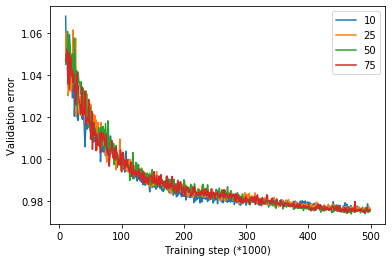

In [3]:
import pickle
import matplotlib.pyplot as plt

with open("plots-for-neck.pkl", "rb") as wp:
    (losses_train, losses_valid) = pickle.load(wp)

# Create a plot

keys = [] 
for key in losses_valid: 
    data = losses_valid[key] 
    plt.plot(range(10, len(data)), data[10:]) 
#     print(data[-1]) 
    keys.append(key)

plt.legend(keys) 
plt.xlabel("Training step (*1000)") 
plt.ylabel("Validation error") 
plt.show()